<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 4 Tutorial: Logistic Regression</h2>
<br>

In this tutorial we discuss how we you can use the logistic regression method in practical business decision-making application to credit risk. 

<a href="#1.-German-Credit-Data">German credit data</a> <br>
<a href="#2.-Business-understanding">Business understanding</a> <br>
<a href="#3.-Exploratory-Data-Analysis">Exploratory data analysis</a> <br>
<a href="#4.-Feature-engineering">Feature engineering</a> <br>
<a href="#5.-Logistic-regression">Logistic regression</a> <br>
<a href="#6.-K-Nearest-neighbours">K-Nearest neighbours</a> <br>
<a href="#7.-Validation metrics">Validation metrics</a> <br>
<a href="#8.-Interpretability">Interpretability</a> <br>

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.model_selection import train_test_split

# 1. German credit data

This tutorial is based on the [German Credit Data](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) available from the UCI Machine Learning repository. Each observation in the dataset represents a loan. The response variable is `default`, which takes a value of one if the client defaulted on the loan and zero if the client repaid the loan in full.

In [4]:
#data = pd.read_csv('Data/german_credit.csv')
data = pd.read_csv('german_credit.csv')
data.head()

,status,duration,history,purpose,amount,savings,employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_under_maintenance,telephone,foreign_worker,default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,1,1,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,0,1,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,0,1,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,0,1,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,0,1,1


There are 13 categorical predictors (two of them binary and already coded numerically) and 7 numerical predictors in the dataset. See the [documentation](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) for the explanation of the variables and the meaning of the levels for the categorical variables. 

In [5]:
# variables = pd.read_csv('Data/german_credit_variables.csv', index_col='variable')
variables = pd.read_csv('german_credit_variables.csv', index_col='variable')
variables = variables['type']

continuous = variables[variables == 'continuous'].index.tolist()
discrete = variables[variables == 'discrete'].index.tolist()
categorical = variables[variables == 'categorical'].index.tolist()
binary = variables[variables == 'binary'].index.tolist()
response = variables[variables == 'response'].index.tolist()

variables.value_counts()

categorical    11
discrete        4
continuous      3
binary          2
response        1
Name: type, dtype: int64

We split the data into training and validation sets, as we've been doing so far. We use stratified sampling,  which ensures that the training and validation sets have the same proportion of defaults. 

In [6]:
data['default'].value_counts(normalize=True).round(3)

0    0.7
1    0.3
Name: default, dtype: float64

In [7]:
index_train, index_valid = train_test_split(np.array(data.index), train_size=0.7, random_state=189)
train = data.loc[index_train,:].copy()
valid = data.loc[index_valid,:].copy()

In [8]:
train['default'].value_counts(normalize=True).round(3)

0    0.679
1    0.321
Name: default, dtype: float64

In [9]:
valid['default'].value_counts(normalize=True).round(3)

0    0.75
1    0.25
Name: default, dtype: float64

In [10]:
index_train, index_valid = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=42)
train = data.loc[index_train,:].copy()
valid = data.loc[index_valid,:].copy()

In [11]:
train['default'].value_counts(normalize=True).round(3)

0    0.7
1    0.3
Name: default, dtype: float64

In [12]:
valid['default'].value_counts(normalize=True).round(3)

0    0.7
1    0.3
Name: default, dtype: float64

Note that stratifying is not only an issue with classifiation, and can be an issue with regression as well. In particular, here we stratify across the predictor variable. 

- But if you have a categorical variable, you can also stratify across those variables as well (imagine if your training set had all females, but the valid had all males).
- If you have continuous variables, then the distribution in the training set may be different to the distribution in the validation set

In [13]:
train.head()

,status,duration,history,purpose,amount,savings,employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_under_maintenance,telephone,foreign_worker,default
10,A12,12,A32,A40,1295,A61,A72,3,A92,A101,...,A123,25,A143,A151,1,A173,1,0,1,1
82,A14,18,A32,A49,1568,A62,A73,3,A92,A101,...,A122,24,A143,A151,1,A172,1,0,1,0
827,A14,18,A30,A49,4165,A61,A73,2,A93,A101,...,A123,36,A142,A152,2,A173,2,0,1,1
410,A12,24,A32,A43,1967,A61,A75,4,A92,A101,...,A123,20,A143,A152,1,A173,1,1,1,0
48,A14,11,A34,A40,7228,A61,A73,1,A93,A101,...,A122,39,A143,A152,2,A172,1,0,1,0


In [14]:
train['personal'].value_counts(normalize=True).round(3)

A93    0.551
A92    0.299
A94    0.096
A91    0.054
Name: personal, dtype: float64

In [15]:
valid['personal'].value_counts(normalize=True).round(3)

A93    0.540
A92    0.337
A94    0.083
A91    0.040
Name: personal, dtype: float64

In [16]:
continuous

['duration', 'amount', 'age']

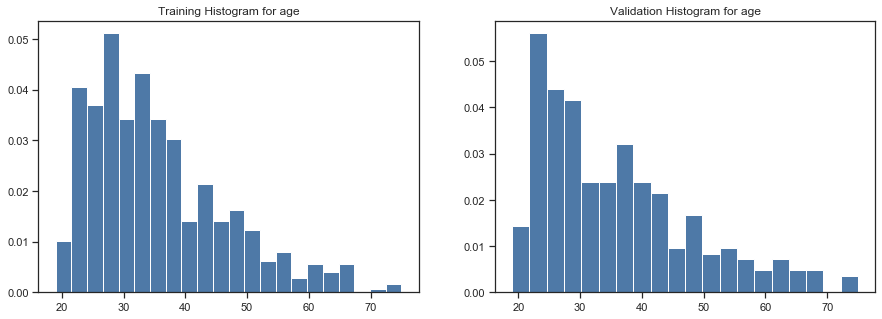

In [17]:
plt.figure(figsize=(15, 5))

col = 'age'

plt.subplot(1, 2, 1)
plt.hist(train[col], bins=22, density=True)
plt.title(f'Training Histogram for {col}')

plt.subplot(1, 2, 2)
plt.hist(valid[col], bins=20, density=True)
plt.title(f'Validation Histogram for {col}');

But in general, the idea of stratification is that you want distributions to be similar on the training set and validation set.

Usually this won't be an issue. But one reason your model may not do as well on the validation set, is that the distributions of the predictors are different for the training vs validation sets.

# 2. Business understanding

The data documentation specifies the following loss matrix: 

<table>
  <tr>
    <th>Actual/ Predicted</th>
    <th>Repayment</th>
     <th>Default</th>
  </tr>
  <tr>
    <th>Repayment</th>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <th>Default</th>
    <td>5</td>
    <td>0</td>
  </tr>
</table>

That is, if we predict a default but the client is creditworthy, the loss is 1.  If we predict that the client will repay the loan but there is a default, the loss is 5. The loss for a correct classification is 0. Using general classificatioon terminology, we say that the loss from a false positive is 1, the loss from a false negative is 5, and the loss from both true positives and true negatives is zero. 

Using the formula from the lecture, the decision threshold is: 

Here we essentially say that 
1. If the true value was default and we predict repay = Penalty is 5 (False Negative)
2. If the true value was repay and we predict default = Penalty is 1 (False Positive)

Then the optimal decision threshold is
$$\frac{\textrm{False Positive}}{\textrm{False Positive} + \textrm{False Negative}} = \frac{1}{1 + 5} = 0.167$$

First recall that our model does not predict 0 or 1. Rather it predictions a probability value, i.e. a number between 0 and 1. The modeller then needs to set a threshold at which we classify things as 0 or 1.

In particular, here our model is predicting if someone defaults. So if your model prediction was $\hat{Y}=0.2$ then
$$\mathbb{P}[\textrm{Customer Default}] = 0.2$$
Again, we are not classifying anything yet, we are only giving a probability. Now depending on the threshold you set the classification will be different.

So if the threshold was $\tau=0.167$ then if the model prediction was $\hat{Y}=0.2\implies \textrm{Default}$.

However, if the threshold was $\tau=0.25$, then if the model prediction was $\hat{Y}=0.2\implies \textrm{Not Default}$

Essentially, the threshold sets the level of confidence you require your model to have. A low threshold would mean that the model requires very little confidence to predict default. While a high threshold would mean that the model requires high confidence to predict default.

In [18]:
tau = 1/(1 + 5)
print(f'Decision threshold: tau = {round(tau,3)}')

Decision threshold: tau = 0.167


If the probability of default is lower than 0.167, then we should classify the client as creditworthy. If the probability of default is higher than 0.167, then we should classify the loan as high risk. 

# 3. Some EDA




## 3.1 Response variable

Defaults occur in 30% of the loans.

In [19]:
data['default'].value_counts(normalize=True)

0    0.7
1    0.3
Name: default, dtype: float64

<BarContainer object of 2 artists>

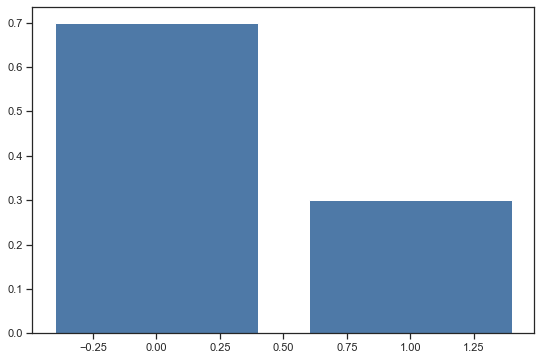

In [20]:
df = data['default'].value_counts(normalize=True)

plt.bar(df.index, df.values)

## 3.2 Continuous predictors 

As common in this type of data, some of the continuous variables are skewed. 

In [21]:
continuous

['duration', 'amount', 'age']

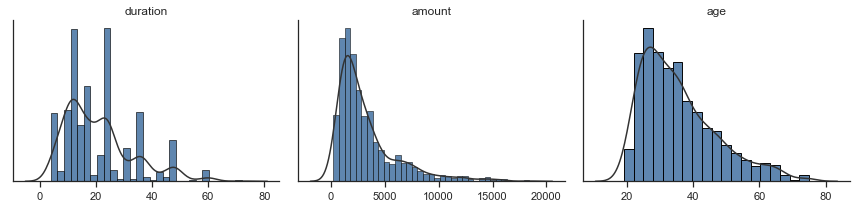

In [22]:
from tutorial4 import distplots

distplots(data[continuous]) 
plt.show()

The risk of default is positively associated with the loan duration and amount.

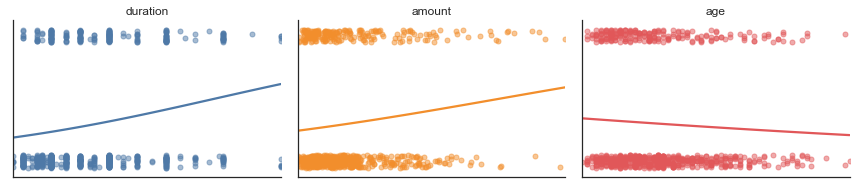

In [23]:
from tutorial4 import regplots

fig, ax = regplots(train[continuous], train['default'])
plt.show()

## 3.2 Discrete and categorical predictors

The following  plots allow us to visualise the relationship between `default` and the remaining variables. The default rates seem to vary significantly according to the status of the existing checking account, savings, and credit history.

In [24]:
discrete + categorical + binary

['installment_rate',
 'residence',
 'existing_credits',
 'people_under_maintenance',
 'status',
 'history',
 'purpose',
 'savings',
 'employment',
 'personal',
 'other_debtors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker']

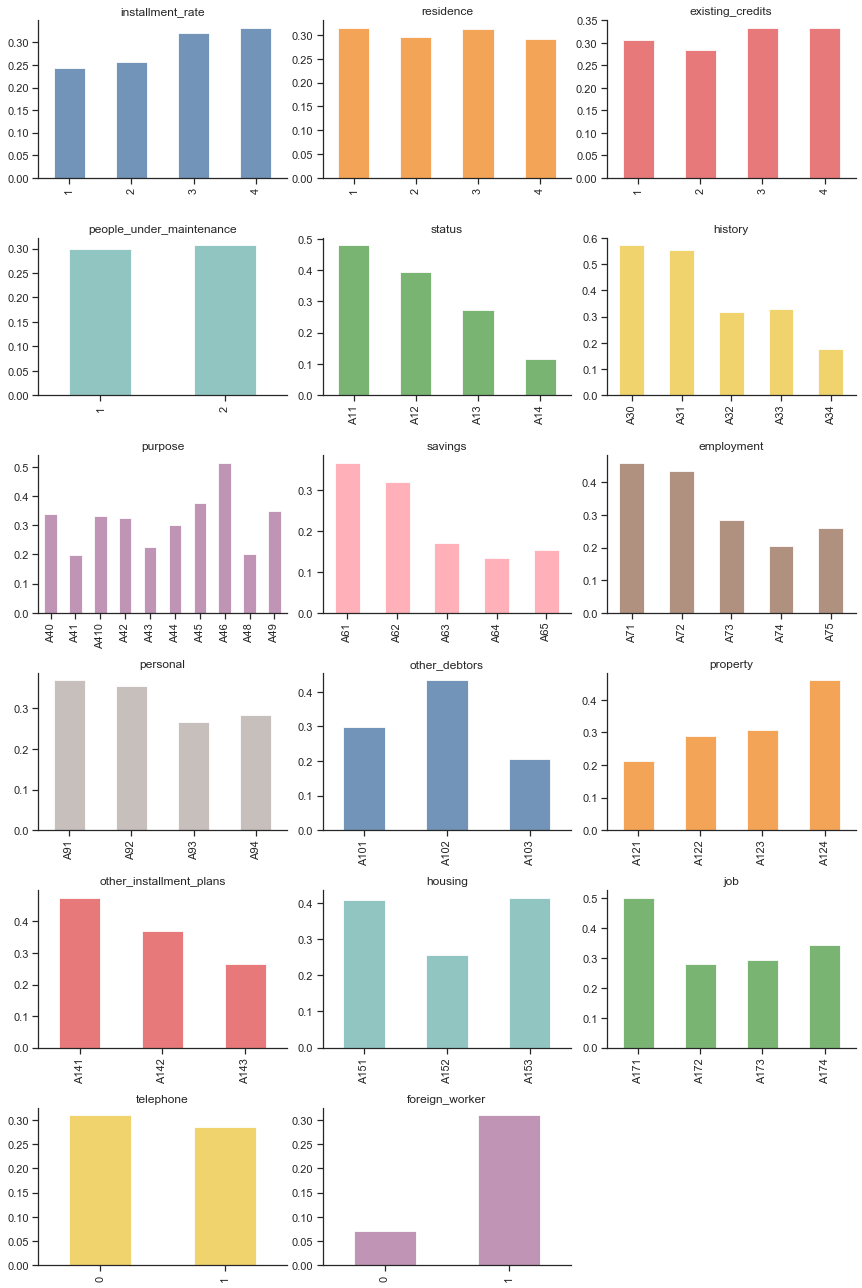

In [25]:
from tutorial4 import crosstabplots

# IMPORTANT : crosstabplots should only be done for discrete/categorical variables
crosstabplots(train[discrete + categorical + binary], train['default'])
plt.show()

## 3.3 Measures of dependence

As we discussed last week, it's useful to estimate the strength of the association between the response and the individual predictors. The common measure of association is the Pearson correlation coefficient, but it's only suitable for measuring the strength of linear relationships between continuous variables. 

In this tutorial, we will the estimate the $\phi_k$ correlation and [mutual information](https://en.wikipedia.org/wiki/Mutual_information). The technical details for both methods are beyond the scope of the unit, so we'll focus just on the interpretation. 

The $\phi_k$ correlation can measure the strength of association between numerical, ordinal and nominal variables. It's based on inverting the $\chi^2$ contingency test statistic that you may have learned about in your basic statistics unit. It has a minimum value of zero and a maximum value of one. The former indicates no dependence and the latter indicates perfect dependence.

According to this measure, `status` is by far the most informative predictor, followed by `duration` and `amount`.

In [26]:
continuous + discrete

['duration',
 'amount',
 'age',
 'installment_rate',
 'residence',
 'existing_credits',
 'people_under_maintenance']

In [27]:
import phik

# ascending = False -> Highest to lowest
data.phik_matrix(interval_cols = continuous + discrete)['default'].sort_values(ascending=False).round(3)

default                     1.000
status                      0.512
duration                    0.285
amount                      0.241
property                    0.217
purpose                     0.204
history                     0.197
age                         0.148
savings                     0.147
personal                    0.123
foreign_worker              0.109
employment                  0.098
housing                     0.077
installment_rate            0.075
other_installment_plans     0.063
other_debtors               0.041
telephone                   0.021
existing_credits            0.000
job                         0.000
people_under_maintenance    0.000
residence                   0.000
Name: default, dtype: float64

The mutual information is a measure of dependence based on [information theory](https://en.wikipedia.org/wiki/Information_theory). Loosely speaking, it measures the distance between the joint distribution and the product of the marginal distributions. Recall that if two random variables are independent, then joint distribution is the product of the marginal distributions.

The mutual information takes a value of zero if there's no dependence. The higher the mutual information, the higher the dependence, but it does not have a fixed maximum value like a correlation. 

The scikit-learn package can estimate mutual information. However, we need to do this separately for continuous and discrete predictors.

In [28]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(data[continuous], data['default'], random_state=1)
results1 = pd.DataFrame(mi, index=continuous, columns=['MI'])

In [29]:
mi

array([0.0334247 , 0.01445127, 0.00306472])

In [30]:
results1

,MI
duration,0.033425
amount,0.014451
age,0.003065


The scikit-learn method only accepts numerical features. Therefore, we have to use the `OrdinalEncoder` to encode the categorical predictors with numerical labels. 

In [31]:
from sklearn.preprocessing import OrdinalEncoder
features = OrdinalEncoder().fit_transform(data[discrete + categorical + binary])

mi = mutual_info_classif(features, data['default'], n_neighbors=5, 
                         random_state=1, discrete_features=True)

results2 = pd.DataFrame(mi, index=discrete + categorical + binary, columns=['MI'])

In [32]:
results2

,MI
installment_rate,0.002753
residence,0.000376
existing_credits,0.001371
people_under_maintenance,0.000005
status,0.065668
history,0.030234
purpose,0.017255
savings,0.019488
employment,0.009082
personal,0.004721


Finally, we concatenate the two sets of results into a single table. 

In [33]:
results = pd.concat([results1, results2], axis=0).sort_values(by='MI', ascending=False).round(4)
results.round(4)

,MI
status,0.0657
duration,0.0334
history,0.0302
savings,0.0195
purpose,0.0173
amount,0.0145
property,0.0118
employment,0.0091
housing,0.0088
other_installment_plans,0.0062


The mutual information estimates can have high variance if there aren't many data points.

# 4. Feature Engineering

We create a function that implements the feature engineering process below. Here are the key details: 

1. Yeo-Johnson transformation for the credit amount and age. The code allows you to verify that these transformations help. 

2. Dummy encoding for the categorical variables (all have low cardinality). 

3. Dummy encoding for the discrete variables (since all have low cardinality).

4. Standardisation for the numerical features (not strictly necessary this time, but it makes the optimisation algorithm more stable). 

In [34]:
binary

['telephone', 'foreign_worker']

In [35]:
labels = continuous
data.loc[index_train, labels]

,duration,amount,age
10,12,1295,25
82,18,1568,24
827,18,4165,36
410,24,1967,20
48,11,7228,39
...,...,...,...
603,36,3349,28
759,12,691,35
298,18,2515,43
417,18,8471,23


In [36]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(df, transformation=True):
    
    data = df.copy()
    
    # Dummy encoding for discrete and categorical variables
    dummies = binary[:] # copies list of binary predictors
    labels = discrete + categorical 
    for label in labels:
        features = pd.get_dummies(data[label], prefix=label, drop_first=True)
        data = data.join(features)
        dummies += list(features.columns)
    
    # Yeo-Johnson transformation
    transf = ['amount', 'age']
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, transf])
        data[transf] = yj_transf.transform(data.loc[:, transf])
    
    # Standardisation
    labels = continuous
    scaler = StandardScaler().fit(data.loc[index_train, labels])
    data.loc[:, labels] = scaler.transform(data.loc[:, labels])
    
    predictors = continuous + dummies
    
    X_train = data.loc[index_train, predictors]
    X_valid = data.loc[index_valid, predictors]

    y_train = data.loc[index_train, response].to_numpy()
    y_valid = data.loc[index_valid, response].to_numpy()
    
    return X_train, np.ravel(y_train), X_valid, np.ravel(y_valid), predictors

X_train, y_train, X_valid, y_valid, predictors = feat_engineering(data)

In [37]:
X_train.head()

,duration,amount,age,telephone,foreign_worker,installment_rate_2,installment_rate_3,installment_rate_4,residence_2,residence_3,...,property_A122,property_A123,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174
10,-0.733512,-0.784457,-1.098310,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
82,-0.231598,-0.528867,-1.275028,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
827,-0.231598,0.737042,0.294312,0,1,1,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0
410,0.270317,-0.229259,-2.120958,1,1,0,0,1,0,0,...,0,1,0,0,1,1,0,0,1,0
48,-0.817165,1.423035,0.559053,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,1,0,0


# 5. Logistic Regression

Training the logistic regression model is simple.

In [38]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none', solver='saga') # using a different solver to avoid numerical errors
logit.fit(X_train, y_train)

LogisticRegression(penalty='none', solver='saga')

# 6. K-Nearest Neighbours

Let's also estimate a KNN classifier for comparison.

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

# 7. Validation

The next cell computes several relevant metrics for the validation set. The most important metric is the estimated risk, which is a direct estimate of the business value of the learned model. 

Here's the interpretation of the other metrics (taking the logistic regression model as an example): 

**Sensitivity:** the model correctly predicted 85.6% of the defaults in the validation set.

**Specificity:** the model correctly predicted 55.7% of repayments in the validation set.

**Precision:** out of the loans that we were classified as high risk, 45.3% were actual defaults. 

**AUC:** the AUC is a measure of how well the model can balance sensitivity and specificity. The better the model predicts the condititional probability of default, the higher the AUC is. The AUC can take values between 0 and 1, with 0.5 corresponding to an uninformative classifier. 

**Cross-entropy**: this is the metric that the learning algorithm optimises on the training set.

In [40]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss
from sklearn.metrics import accuracy_score

columns=['Estimated risk', 'SE', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic Regression', 'KNN']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, knn]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    
    # Probability of Defaulting for the given method
    y_prob[:, i] = method.predict_proba(X_valid)[:, 1]
    
    # Classification using the decision threshold
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss = 5*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(loss))
    results.iloc[i,2] =  accuracy_score(y_valid, y_pred)
    results.iloc[i,3] =  tp/(tp+fn)
    results.iloc[i,4] =  tn/(tn+fp)
    results.iloc[i,5] =  precision_score(y_valid, y_pred)
    results.iloc[i,6] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,7] =  log_loss(y_valid, y_prob[:,i])

results.round(3)

,Estimated risk,SE,Accuracy,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic Regression,0.527,0.061,0.647,0.856,0.557,0.453,0.791,0.496
KNN,0.520,0.041,0.533,0.956,0.352,0.387,0.758,0.523


<table>
  <tr>
    <th>Actual/ Predicted</th>
    <th>Repayment</th>
     <th>Default</th>
  </tr>
  <tr>
    <th>Repayment</th>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <th>Default</th>
    <td>5</td>
    <td>0</td>
  </tr>
</table>

Equivalently


|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        0     |     1      | 
|$Y_{true} = 1$|  5         |      0       |

In [41]:
1*((y_pred!=y_valid) & (y_pred==1))

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [42]:
((y_pred == 1) & (y_valid == 0)) * 1

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

We can plot the ROC as follows: 

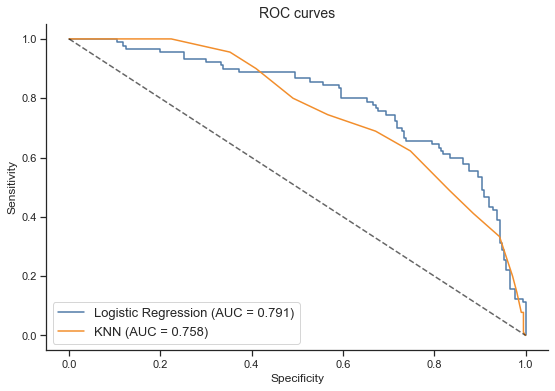

In [43]:
from tutorial4 import rocplot
fig, ax = rocplot(y_valid, y_prob, labels=pd.Series(rows))
plt.show()


|            | $Y_{pred} = 0$ | $Y_{pred} = 1$ |
|------------|--------------|--------------|
|$Y_{true} = 0$|        True Negatives     |     False Positives      | 
|$Y_{true} = 1$|  False Negatives         |      True Positives       |

It will take more time to explain this than I have in the tutorial, but 

- If you increase the **true positives** you will decrease the **true negatives**, and 
- When you increase the **true negatives** you will decrease the **true positives**. 

Now sensitivity ~ true positives, and specificity ~ true negatives. So 
- If you increase the **sensitivity** you will decrease the **specificity**, and 
- When you increase the **specificity** you will decrease the **sensitivity**. 

# 8. Interpretability

In many applications, not only care about the predictive performance of a machine learning model, but want to understand why it makes certain predictions.

Credit risk is a good example: loan approvals are high-stake decisions, so we don't want to blindly trust machine learning algorithms with them. Furthermore, if a financial institution denies credit, it's expected to explain its decision to the client (in many countries, this is a regulatory requirement). "Because the machine learning algorithm says so" won't cut it!

The logistic regression model has the advantage of being quite interpretable. You can retrieve the estimated parameters as follows: 

In [44]:
for i, predictor in enumerate(predictors[:5]):
    print(f'{predictor}: {logit.coef_[0, i]:.3f}')

duration: 0.448
amount: 0.092
age: -0.097
telephone: -0.227
foreign_worker: 1.694


The following figure can help us to visualise the largest coefficients. However, one limitation of this plot is that the continuous and binary predictors are not on the same scale and therefore are not comparable.

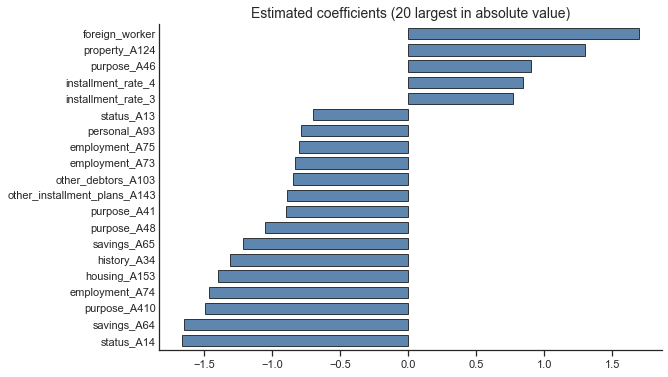

In [45]:
from tutorial4 import coefplot

coefplot(logit, predictors)
plt.show()

In this unit, we'll use the [SHAP](https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) (Shapley additive explanations) approach to interpret machine learning model predictions.

We'll discuss this in a future lecture. What you should know for now is that a SHAP value measures how much the value of feature $j$ contributed to the prediction for observation $i$ compared to the average prediction for the dataset. 

For the logistic regression model, this is just (referring to the prediction on the logit scale):

$\phi_{ij}=\widehat{\beta}_jx_{i,j}-\widehat{\beta}_j\overline{x}_j$

Now, suppose that we want to interpret the output for validation case 9, for which the model predicts default. The main reason is that the loan duration is high. 

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

https://github.com/slundberg/shap

In [46]:
import shap
print(shap.__version__)

0.39.0


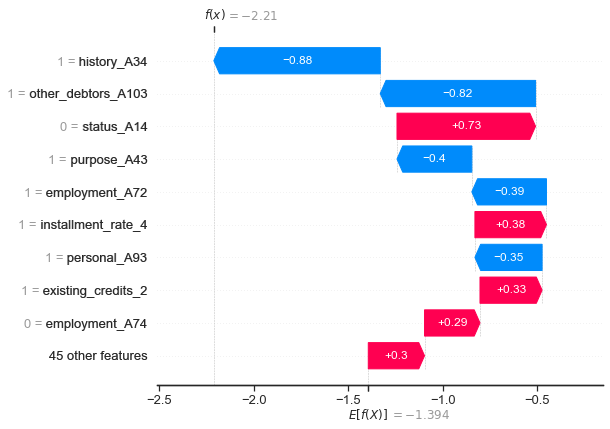

In [172]:
import shap
shap.initjs()

explainer = shap.Explainer(logit, X_train)
shap_values = explainer(X_valid)

shap.plots.waterfall(shap_values[1])

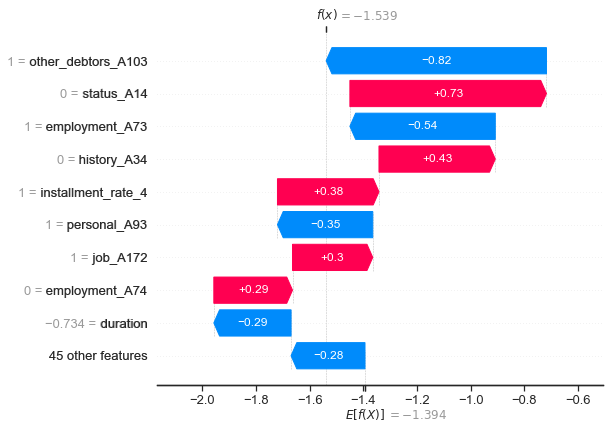

In [171]:
import shap
shap.initjs()

explainer = shap.Explainer(logit, X_train)
shap_values = explainer(X_valid)

shap.plots.waterfall(shap_values[4])

A force plot gives an alternative visualisation:

In [48]:
shap.plots.force(shap_values[2])

In the terminology of machine learning interpretability, the above plot is a local explanation:  it explains a single prediction.

In contrast, global explanations refer to behaviour of the model over the entire dataset. The following figures plots the SHAP values for the entire training set. 

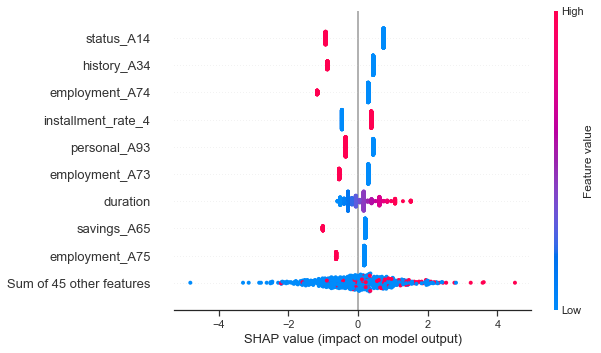

In [49]:
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

The average of the SHAP values provides a measure of feature importance. The three features with largest impact on the predictions are whether the client has no property, whether the client has an account with critical status, and whether the client has no checking account.  

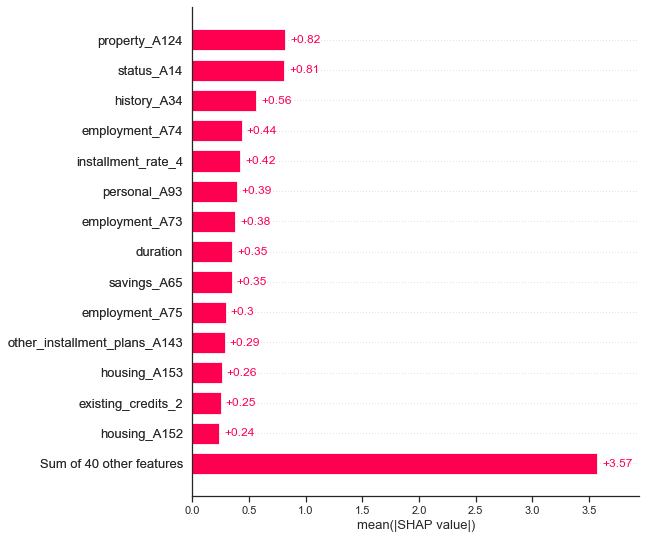

In [50]:
shap.plots.bar(shap_values, max_display=15) 

In [63]:
X_train.head()

,duration,amount,age,telephone,foreign_worker,installment_rate_2,installment_rate_3,installment_rate_4,residence_2,residence_3,...,property_A122,property_A123,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174
10,-0.733512,-0.784457,-1.098310,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
82,-0.231598,-0.528867,-1.275028,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
827,-0.231598,0.737042,0.294312,0,1,1,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0
410,0.270317,-0.229259,-2.120958,1,1,0,0,1,0,0,...,0,1,0,0,1,1,0,0,1,0
48,-0.817165,1.423035,0.559053,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,1,0,0


In [164]:
X_train_copy = X_train.copy()

X_train_copy.loc[:, 'property_A124'] = 0
np.mean(knn.predict_proba(X_train_copy)[:, 1])

0.2834761904761905

In [165]:
X_train_copy = X_train.copy()

X_train_copy.loc[:, 'property_A124'] = 1
np.mean(knn.predict_proba(X_train_copy)[:, 1])

0.2922857142857143

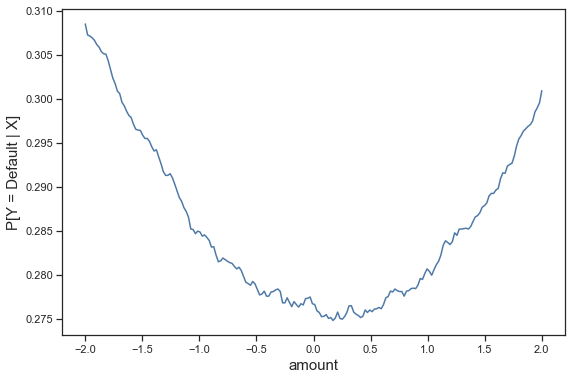

In [166]:
X_train_copy = X_train.copy()

average_predictions = []
x_vals = np.linspace(-2, 2, 200)

col = 'amount'

for x in x_vals:
    X_train_copy.loc[:, col] = x
    val = np.mean(knn.predict_proba(X_train_copy)[:, 1])
    
    average_predictions.append(val)

plt.plot(x_vals, average_predictions)
plt.xlabel(col, fontsize=15);
plt.ylabel("P[Y = Default | X]", fontsize=15);

In [101]:
X_train_copy = X_train.copy()

average_predictions = []
x_vals = np.linspace(-2, 2, 100)

col = 'amount'

for x in x_vals:
    X_train_copy.loc[:, col] = x
    predictions = logit.predict_proba(X_train_copy)[:, 1]
    
    average_predictions.append(predictions)
average_predictions = np.array(average_predictions)

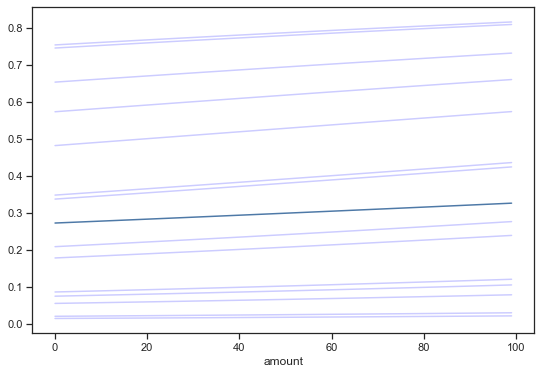

In [102]:
plt.plot(average_predictions.mean(axis=1))
plt.plot(average_predictions[:, ::50], alpha=0.2, color='blue');
plt.xlabel(col);